loss 0.171, train acc 0.935, test acc 0.950
79.4 examples/sec on [device(type='cuda', index=0)]


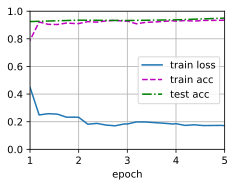

In [1]:
import torch
import torchvision
from d2l import torch as d2l
import os
from torch import nn
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')
data_dir = d2l.download_extract('hotdog')

train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))


# Specify means and standard deviations of three RGB channels to standardize each channel
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Using the mean and std of Imagenet is a common practice. They are calculated
# based on millions of images. If you want to train from scratch on your own
# dataset, you can calculate the new mean and std. Otherwise, using Imagenet
# pretrained model with its own mean and std is recommended.


train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(), normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(), normalize])


# If `param_group=True`, parameters in output layer are updated using learning rate 10 times greater
def train_fine_tuning(net, learning_rate, batch_size=64, num_epochs=5, param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs), batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs), batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters() # all parameters not in output layer
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x}, {'params': net.fc.parameters(),
                  'lr': learning_rate * 10}], lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

def transform_fc_train(model):
    model.fc = nn.Linear(model.fc.in_features, 2)   # change no. of classes to 2
    nn.init.xavier_uniform_(model.fc.weight)
    train_fine_tuning(model, 5e-5)
# Fine-tuning
# using ResNeSt-50 as an example
# get list of models
torch.hub.list('zhanghang1989/ResNeSt', force_reload=True)

# load pretrained models, using ResNeSt-50 as an example
resnest50_pretrained = torch.hub.load('zhanghang1989/ResNeSt', 'resnest50', pretrained=True)
transform_fc_train(resnest50_pretrained)


loss 0.237, train acc 0.918, test acc 0.907
107.7 examples/sec on [device(type='cuda', index=0)]


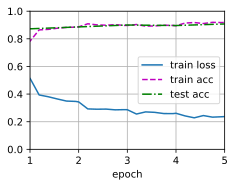

In [2]:
from torchvision.models import resnet50,ResNet50_Weights
resnet50_pretrained = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
transform_fc_train(resnet50_pretrained)